## Analyzing the Scree-Plot of a Low-Rank Sample Covariance
This document studies the eigen-spectrum of a low-rank covariance matrix (i.e, its [scree-plot](http://www.janda.org/workshop/factor%20analysis/SPSS%20run/SPSS08.htm)). The data contains a multivariate signal comprised of k uncorrelated components each with variance, &#955;i (i =1,...,k). Componets are mixed by a low-rank matrix, **A**, of dimension nxk and added with white Gaussian noise, N(0,&#963;I).  
$${\bf x} = {\bf As}+n$$
This model is suitable for describing many linear admixture models. Since this document is concerned with model order estimation, we are particularly interested when this model can be used to estimate the number of independent sources (i.e., dimension of **s**). 

- NOTE: model order selection using Maximum Likelihood is not possible for all linear admixture models. Using ML is only useful when sources are assumed to be independent (such as ICA,PCA, etc.). On the other hand, signal processing approaches such as neural networks (which can be formulated with an admixture model) are not suitable for ML-based model order selection. This is because without the assumption of independence (which is the case in Neural Networks), adding the dimension monotonically increases the Likelihood function without any restriction (the higher the dimension, the higher the likelihood). However, under the independence assumption, adding too many sources will reduce the likelihood function [4], therefore one should expect a tipping point in the likelihood function. 

In [5]:
import numpy as np
n = 20
k = 3
Lambda = [i for i in range(100,2,-1)]
Lambda = Lambda[:k]
sigma = min(Lambda)

In our example, we define the bases nxk mixing matrix, **A**, using random Gaussian vectors. 

In [6]:
A = np.random.randn(n,k)
N = 50
s = np.zeros((k,N))
for i in range(k):
    s[i,:] = np.sqrt(Lambda[i])*np.random.randn(1,N)
X =  np.dot(A,s) + np.sqrt(sigma)*np.random.randn(n,N)

Now, Calculate the sample covariance matrix of **x**:
$${\bf R_x} = \frac{1}{N}{\bf X}{\bf X}^T$$
where **X** is the collection of **x** vectors. 

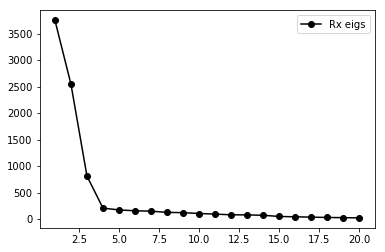

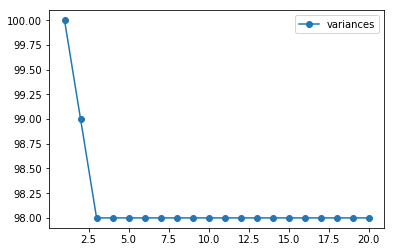

In [7]:
Rx = np.dot(X,X.T)
V = np.linalg.eigvals(Rx/(N))
V = np.sort(V)[::-1]
#V = np.sqrt(V)
import pylab
pylab.figure()
pylab.plot(np.arange(n)+1,V,'ko-',label='Rx eigs')
pylab.legend()
pylab.figure()
Vtrue = np.array(Lambda+[sigma]*(n-k))
pylab.plot(np.arange(n)+1,Vtrue,'o-',label='variances')
pylab.legend()
pylab.show()

### Discussion
The main question here is: what causes the difference between the left and right plots?

- An important reason is the limitted number of samples (i.e., `N`) relative to the number of components (k). 
According to [1], the sample covariance matrix, `Rx`(which is obtained from mixing uncorrelated Gaussian components) has a Wishart distribution. The eigenvalues of a sample from the Wishart distribution deviate from the true Eigenvalues as a function of k/N (i.e., the number of components divided by the total number of samples). This causes the left scree-plot to be different from the right plot. 
Because of the form of the eigenvalue deviation, the scree-plot cannot be simply corrected by increasing N. [2] provides a solution to correct the empirical scree-plot by adjusting the eigenvalues of the sample covariance matrix against the eigenspectrum of a standard Gaussian matrix. 

### Eigen-spectrum Correction
According to [2], the eigenvalues can be corrected by dividing each eigenvalue by the inverse of the cummulative function, corresponding to the following function:

$$g(v) = \frac{1}{2\pi \gamma v}\sqrt{(v-b_-)(b_+-v)}. $$

where $\gamma$ is k/N (the number of components divided by the number of samples), and $b_{\pm} = (1\pm\gamma)^2$. 
An implementation of this correction has been provided by the authors of [3], which I have included below: 


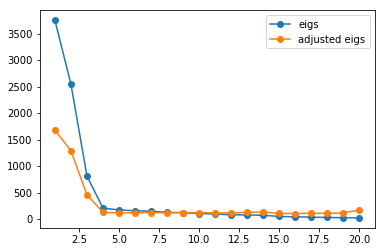

In [8]:
r = float(n)/N
pi = np.pi 
bp = (1+np.sqrt(r))**2
bm = (1-np.sqrt(r))**2

vv = np.arange(bm,bp,(bp-bm)/(5.*n - 1.))
gv = np.divide(1.,(2*pi*r*vv))*np.sqrt(np.multiply(vv-bm,bp-vv))

gvd = np.zeros(gv.shape)
for i in range(len(gv)):
    gvd[i] = np.sum(gv[:i])

gvd = gvd/np.max(gvd);

lam_emp = np.zeros(np.shape(V));
for i in range(n):
    i_norm = float(i)/n;
    minv = np.min(np.abs(i_norm-gvd))
    minx = np.argmin(np.abs(i_norm-gvd))
    lam_emp[i] = vv[minx];
lam_emp = lam_emp[::-1]
Vadj = np.divide(V,lam_emp)
pylab.plot(np.arange(n)+1,V,'o-',label='eigs')
pylab.plot(np.arange(n)+1,Vadj,'o-',label='adjusted eigs')
pylab.legend()
pylab.show()


### References
[1] Everson, Richard, and Stephen Roberts. "Inferring the eigenvalues of covariance matrices from limited, noisy data." IEEE transactions on signal processing 48.7 (2000): 2083-2091.

[2] Beckman, C. F., and S. M. Smith. "Probabilistic independent component analysis for function magnetic resonance imaging." IEEE Transactions on Medical Imaging 23 (2004): 137-152.

[3] Li, Yi‐Ou, Tülay Adalı, and Vince D. Calhoun. "Estimating the number of independent components for functional magnetic resonance imaging data." Human brain mapping 28.11 (2007): 1251-1266.

[4] Penny, W., R. Everson, and S. Roberts. "ICA: model order selection and dynamic source models." Independent component analysis: Principles and practice (2001): 299-314.